<a href="https://colab.research.google.com/github/lifahjdm/Birds-Recognition/blob/main/Birds_Species_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
import pandas as pd
import numpy as np
import librosa
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import re

In [5]:
# path to the dataset
dir ='/content/drive/MyDrive/Birds Species Recognizing/Voice of Birds'
birds_list = os.listdir(dir)

In [6]:
# Create DataFrame
df = pd.DataFrame()
df['chirps'] = birds_list

# Extract Labels (Birds Species) from filenames
df['labels'] = [re.sub(r'\d+\.mp3$', '', audio) for audio in birds_list]

df.head()

,chirps,labels
0,Cinereous Tinamou5.mp3,Cinereous Tinamou
1,Cinereous Tinamou6.mp3,Cinereous Tinamou
2,Cinereous Tinamou30.mp3,Cinereous Tinamou
3,Cinereous Tinamou7.mp3,Cinereous Tinamou
4,Cinereous Tinamou3.mp3,Cinereous Tinamou


In [7]:
df.groupby('labels')['labels'].count()

,labels
labels,
Andean Guan,30
Andean Tinamou,30
Band-tailed Guan,30
Bartletts Tinamou,30
Black-capped Tinamou,30
Blue-throated Piping Guan,30
Brazilian Tinamou,30
Brown Tinamou,30
Cauca Guan,30


In [8]:
num_labels = df['labels'].nunique()
print(f"Jumlah spesies: {num_labels}")

Jumlah spesies: 45


In [9]:
df['labels'].value_counts().sum()

1350

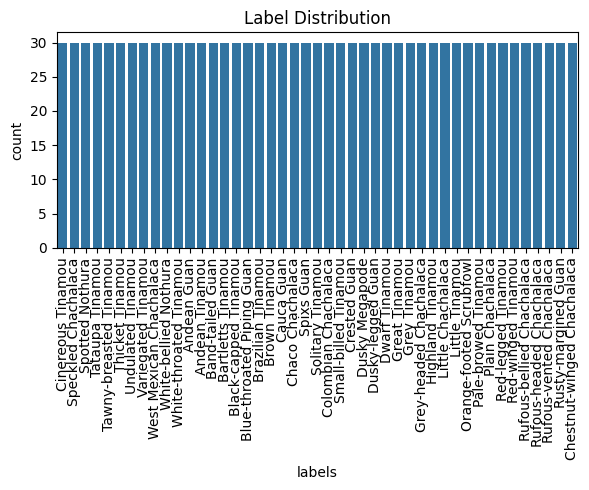

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize the original label distribution
plt.figure(figsize=(6, 5))
sns.countplot(data=df, x='labels', order=df['labels'].value_counts().index)
plt.title('Label Distribution')
plt.xticks(rotation=90)

# Show the plot
plt.tight_layout()
plt.show()


Untuk mengekstrak fitur MFCC dari audioset

In [11]:
# Feature extraction function
def extract_mfcc(file_path, n_mfcc=13):
    audio, sr = librosa.load(file_path, sr=None)
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    mfcc_mean = np.mean(mfcc, axis=1)
    return mfcc_mean

Membuat list kosong untuk menyimpan fitur MFCC dari audioset

In [12]:
# Extract features for all audio files
features = []
for file in df['chirps']:
    file_path = os.path.join(dir, file)
    mfcc = extract_mfcc(file_path)
    features.append(mfcc)

<ipython-input-11-e6789200ef68>:3: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(file_path, sr=None)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Mengkonversi list features yang berisi vektor MFCC ke dalam array NumPy X. Ini penting karena machine learning model biasanya bekerja dengan array NumPy.

Mengambil nilai dari kolom 'labels' dari DataFrame df dan menyimpannya dalam array NumPy y. y kemungkinan berisi label atau kelas yang sesuai dengan setiap file audio.

In [13]:
# Convert features to a numpy array
X = np.array(features)
y = df['labels'].values

#Print the shape of X and y to see the data structure
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (1350, 13)
Shape of y: (1350,)


X: terdapat 1350 sampel audio, dan setiap sampel direpresentasikan oleh vektor fitur dengan 13 elemen (sesuai dengan n_mfcc=13).

y: Mencetak dimensi array y. Output (1350,) menunjukkan bahwa terdapat 1350 label, satu untuk setiap sampel audio.

In [14]:
# Mengkodekan label sebagai integer
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [15]:
import pickle

# Simpan LabelEncoder ke file untuk proses deployment
with open('label_encoder.pkl', 'wb') as file:
    pickle.dump(label_encoder, file)

In [16]:
# Apply RandomOverSampler to balance the classes
ros = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y_encoded)

# Convert the resampled encoded labels back to the original labels
y_resampled_labels = label_encoder.inverse_transform(y_resampled)

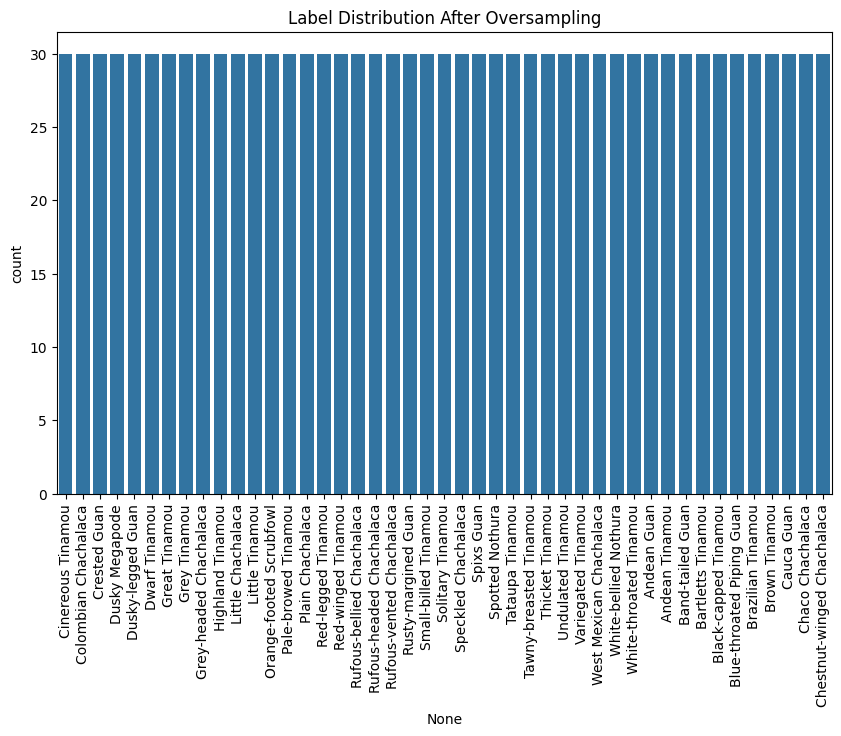

In [17]:
# Visualize the label distribution after oversampling
plt.figure(figsize=(10, 6))
sns.countplot(x=pd.Series(y_resampled_labels))
plt.title('Label Distribution After Oversampling')
plt.xticks(rotation=90)
plt.show()

In [18]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled_labels, test_size=0.2, random_state=42)

# Reshape data for CNN input
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Visualize the shape of training and testing data
print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

# Print the shapes of y_train and y_test
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

Training data shape: (1080, 13, 1)
Testing data shape: (270, 13, 1)
y_train shape: (1080,)
y_test shape: (270,)


Data telah berhasil dipisahkan menjadi training set (80%) dan test set (20%) menggunakan train_test_split

# **Modelling**

Model menggunakan Flatten layer untuk mengubah keluaran 3D dari layer konvolusi menjadi 1D sebelum masuk ke layer fully connected.

Optimizer Adam dengan parameter default.

Tidak menggunakan Learning Rate Scheduler.

Melatih model hingga 50 epoch dengan EarlyStopping yang menghentikan pelatihan jika tidak ada peningkatan selama 5 epoch.



In [19]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

# Ensure the labels are encoded as integers (this should already be done)
# Using the previously encoded labels
y_train_encoded = label_encoder.transform(y_train)  # Use LabelEncoder's transform method
y_test_encoded = label_encoder.transform(y_test)

# Now, one-hot encode the labels
y_train_encoded = to_categorical(y_train_encoded)
y_test_encoded = to_categorical(y_test_encoded)

# Build the CNN model
# Hyperparameter tuning & Model improvements
from tensorflow.keras.layers import BatchNormalization

# Build the CNN model
model = Sequential()

# First convolutional layer with normalization
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(BatchNormalization())  # Added batch normalization
model.add(MaxPooling1D(pool_size=2))

# Second convolutional layer
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(BatchNormalization())  # Added batch normalization
model.add(MaxPooling1D(pool_size=2))

# Flatten the output of convolutional layers
model.add(Flatten())

# Fully connected layer
model.add(Dense(128, activation='relu'))

# Dropout for regularization
model.add(Dropout(0.5))

# Output layer
model.add(Dense(len(np.unique(y_train)), activation='softmax'))

# Compile the model with a lower learning rate for more stable convergence
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

# Train the model with early stopping to avoid overfitting
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train_encoded, epochs=50, batch_size=32, validation_data=(X_test, y_test_encoded), callbacks=[early_stopping])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 11, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 11, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 5, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 3, 128)              │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 3, 128)              │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 45)                  │           5,805 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 48,045 (187.68 KB)

 Trainable params: 47,661 (186.18 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.0358 - loss: 4.5193 - val_accuracy: 0.0593 - val_loss: 3.6867
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1306 - loss: 3.4265 - val_accuracy: 0.1222 - val_loss: 3.5375
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1978 - loss: 3.1543 - val_accuracy: 0.1926 - val_loss: 3.3862
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2320 - loss: 2.9858 - val_accuracy: 0.2296 - val_loss: 3.2516
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2669 - loss: 2.8712 - val_accuracy: 0.3296 - val_loss: 3.0693
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3052 - loss: 2.6530 - val_accuracy: 0.3259 - val_loss: 2.9841
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3538 - loss: 2.5587 - val_accuracy: 0.3519 - val_loss: 2.7473
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3581 - loss: 2.4360 - val_accuracy: 0.3778 - val_loss

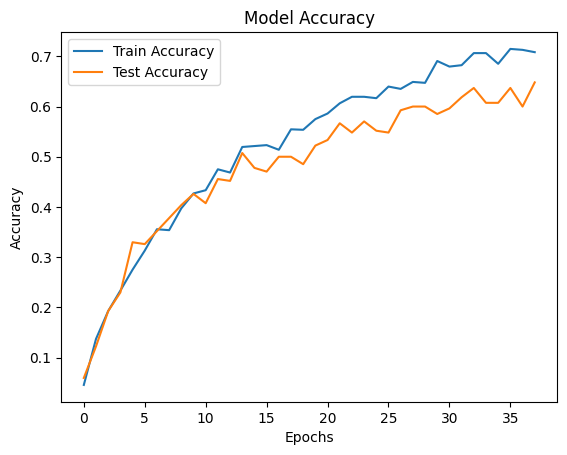

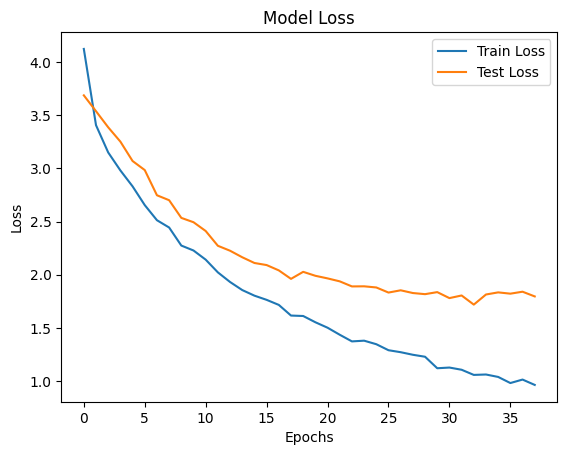

In [20]:
# Visualize the training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Visualize the training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [21]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix

# Evaluasi model
loss, accuracy = model.evaluate(X_test, y_test_encoded)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6344 - loss: 1.6900 
Test Loss: 1.7191144227981567
Test Accuracy: 0.6370370388031006


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Predicted Accuracy: 0.6370370370370371


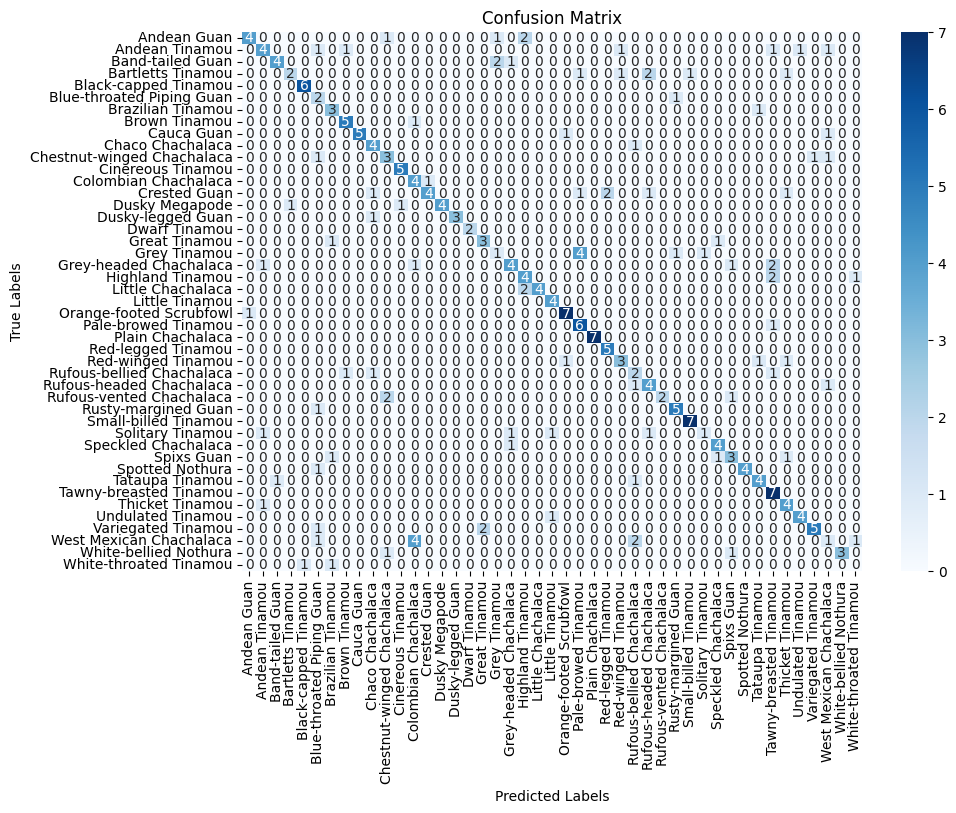

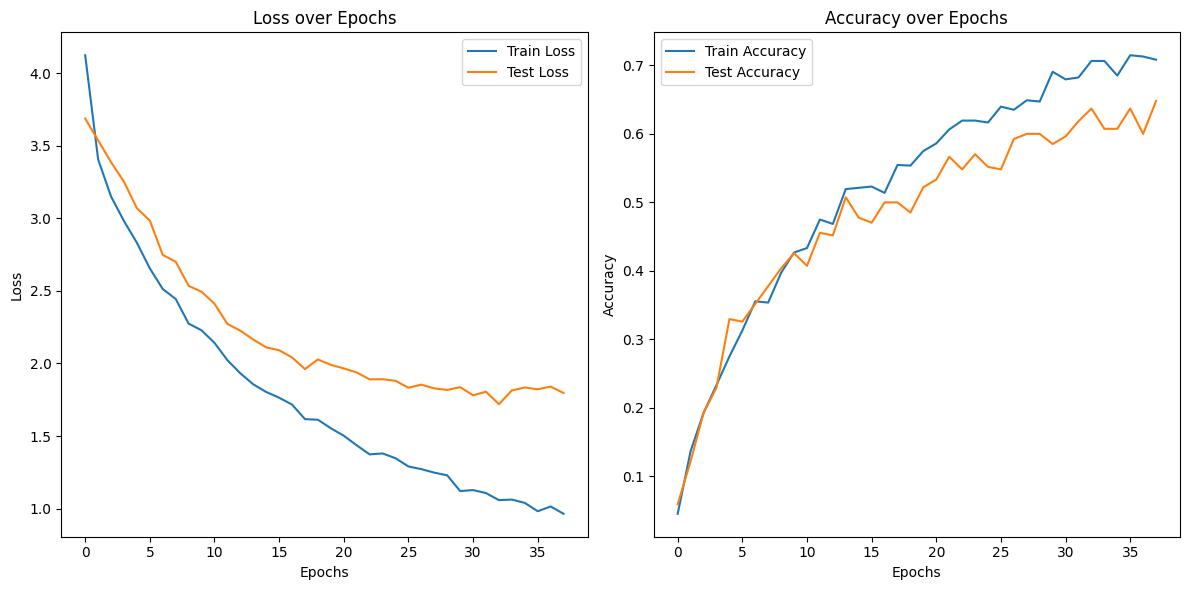

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicted class for the sample: Highland Tinamou


In [22]:
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Menggunakan np.argmax untuk mendapatkan kelas dengan probabilitas tertinggi
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)  # Ambil kelas dengan probabilitas tertinggi

# Menggunakan label_encoder untuk mengonversi y_test kembali ke label integer jika diperlukan
# Misalnya y_test sudah ter-encode, maka kita bisa langsung menggunakan y_test
# Pastikan y_test adalah integer encoded labels, bukan one-hot
# Misalnya, jika y_test sudah berupa integer (hasil transformasi dengan LabelEncoder), kita bisa menggunakan langsung.

y_test_int = label_encoder.transform(y_test)  # Mengubah y_test menjadi integer encoded jika diperlukan

# Menghitung akurasi prediksi
accuracy_pred = accuracy_score(y_test_int, y_pred)
print(f"Predicted Accuracy: {accuracy_pred}")

# Confusion Matrix
cm = confusion_matrix(y_test_int, y_pred)

# Visualisasi Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Plot Training and Testing Loss & Accuracy
plt.figure(figsize=(12, 6))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Contoh prediksi untuk sample dari X_test
sample_index = 0  # Ambil indeks sample pertama
sample = X_test[sample_index].reshape(1, X_test.shape[1], 1)  # Reshape untuk input model

# Prediksi label untuk sample
predicted_label = model.predict(sample)
predicted_class = label_encoder.inverse_transform([np.argmax(predicted_label)])

print(f"Predicted class for the sample: {predicted_class[0]}")



In [23]:
model.save('cnn.h5')

In [24]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Get predicted labels (integers) from model output
y_pred_labels = np.argmax(model.predict(X_test), axis=1)

# Convert one-hot encoded y_true to integer labels
y_true_labels = np.argmax(y_test_encoded, axis=1)

# Now, calculate metrics using the integer labels
accuracy = accuracy_score(y_true_labels, y_pred_labels)

precision = precision_score(y_true_labels, y_pred_labels, average='weighted')
recall = recall_score(y_true_labels, y_pred_labels, average='weighted')
f1 = f1_score(y_true_labels, y_pred_labels, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

print("\nClassification Report:")
print(classification_report(y_true_labels, y_pred_labels))

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Accuracy: 0.6370370370370371
Precision: 0.670051440329218
Recall: 0.6370370370370371
F1 Score: 0.6282155782654578

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.50      0.62         8
           1       0.57      0.40      0.47        10
           2       0.80      0.57      0.67         7
           3       0.67      0.25      0.36         8
           4       0.86      1.00      0.92         6
           5       0.25      0.67      0.36         3
           6       0.50      0.75      0.60         4
           7       0.71      0.83      0.77         6
           8       1.00      0.71      0.83         7
           9       0.57      0.80      0.67         5
          10       0.43      0.50      0.46         6
          11       0.83      1.00      0.91         5
          12       0.40      0.80      0.53         5
          13       0.80      0.40      0.53        10
          14 

In [25]:
df.groupby('labels')['labels'].count()

,labels
labels,
Andean Guan,30
Andean Tinamou,30
Band-tailed Guan,30
Bartletts Tinamou,30
Black-capped Tinamou,30
Blue-throated Piping Guan,30
Brazilian Tinamou,30
Brown Tinamou,30
Cauca Guan,30


In [26]:
import librosa
import numpy as np
from tensorflow.keras.models import load_model

# Fungsi untuk mengekstrak MFCC dari file audio
def extract_mfcc(file_path, n_mfcc=13):
    audio, sr = librosa.load(file_path, sr=None)
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    mfcc_mean = np.mean(mfcc, axis=1)  # Rata-rata untuk setiap koefisien MFCC
    return mfcc_mean

# Path ke file audio yang ingin diprediksi
example_file = '/content/drive/MyDrive/Birds Species Recognizing/Voice of Birds/White-throated Tinamou31.mp3'

# Ekstraksi fitur MFCC dari file audio
mfcc_features = extract_mfcc(example_file)

# Reshape untuk menyesuaikan dengan input model (1, n_features, 1)
mfcc_features_reshaped = mfcc_features.reshape(1, mfcc_features.shape[0], 1)

# Memuat model yang sudah dilatih (misalnya model yang telah disimpan sebelumnya)
# Jika model sudah dilatih sebelumnya, muat model dengan cara ini:
model = load_model('cnn.h5')  # Gantilah dengan path model Anda jika sudah disimpan

# Lakukan prediksi
predicted_prob = model.predict(mfcc_features_reshaped)
predicted_class = np.argmax(predicted_prob, axis=1)

# Mengonversi hasil prediksi kembali ke label asli menggunakan LabelEncoder
predicted_label = label_encoder.inverse_transform(predicted_class)

print(f"Predicted label for the audio file: {predicted_label[0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
Predicted label for the audio file: White-throated Tinamou



-

-

-

-

-

-

-

-

-

-

-



























Model kedua

1. Menggunakan GlobalAveragePooling1D untuk membantu mengurangi jumlah parameter, membuat model lebih kompak, dan cenderung lebih baik untuk mencegah overfitting.

2. Menggunakan Optimizer Adam dengan learning rate yang disesuaikan (learning_rate=0.0005)

3. Menggunakan LearningRateScheduler, di mana learning rate berkurang sebesar 30% setiap 10 epoch. Fungsi: Penurunan learning rate secara bertahap membantu pelatihan model menjadi lebih stabil saat mendekati konvergensi.

4. Melatih model hingga 100 epoch, menggunakan kombinasi: EarlyStopping untuk mencegah overfitting. Learning Rate Scheduler untuk mengoptimalkan konvergensi.


In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

# Hyperparameter tuning & Model improvements
model = Sequential()

# First convolutional layer with normalization
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(BatchNormalization())  # Added batch normalization
model.add(MaxPooling1D(pool_size=2))

# Second convolutional layer
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(BatchNormalization())  # Added batch normalization
model.add(MaxPooling1D(pool_size=2))

# Global Average Pooling layer to reduce overfitting and make the model more robust
model.add(GlobalAveragePooling1D())

# Fully connected layer
model.add(Dense(128, activation='relu'))

# Dropout for regularization
model.add(Dropout(0.5))

# Output layer
model.add(Dense(len(np.unique(y_train)), activation='softmax'))

# Optimizer with adjusted learning rate (lower rate for stability)
optimizer = Adam(learning_rate=0.0005)  # Adjusted learning rate

# Compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

# Learning rate scheduler to reduce learning rate as training progresses
def lr_schedule(epoch, lr):
    if epoch % 10 == 0 and epoch > 0:
        lr = lr * 0.7  # Reduce learning rate by 30% every 10 epochs
    return lr

lr_scheduler = LearningRateScheduler(lr_schedule)

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping and learning rate scheduler
history = model.fit(X_train, y_train_encoded, epochs=100, batch_size=32, validation_data=(X_test, y_test_encoded), callbacks=[early_stopping, lr_scheduler])



/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)                    │ (None, 11, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 11, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 5, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 3, 128)              │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 3, 128)              │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 45)                  │           5,805 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 48,045 (187.68 KB)

 Trainable params: 47,661 (186.18 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.0381 - loss: 4.6226 - val_accuracy: 0.0370 - val_loss: 3.9980 - learning_rate: 5.0000e-04
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0783 - loss: 3.7005 - val_accuracy: 0.0630 - val_loss: 3.6581 - learning_rate: 5.0000e-04
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1322 - loss: 3.4643 - val_accuracy: 0.1148 - val_loss: 3.5301 - learning_rate: 5.0000e-04
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1841 - loss: 3.1910 - val_accuracy: 0.1926 - val_loss: 3.4275 - learning_rate: 5.0000e-04
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2005 - loss: 3.1264 - val_accuracy: 0.2000 - val_loss: 3.3143 - learning_rate: 5.0000e-04
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2595 - loss: 2.9191 - val_accuracy: 0.2481 - val_loss: 3.1804 - learning_rate: 5.0000e-04
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2739

In [28]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix

# Evaluasi model
loss, accuracy = model.evaluate(X_test, y_test_encoded)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5822 - loss: 1.8208 
Test Loss: 1.8184118270874023
Test Accuracy: 0.5814814567565918


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Predicted Accuracy: 0.5814814814814815


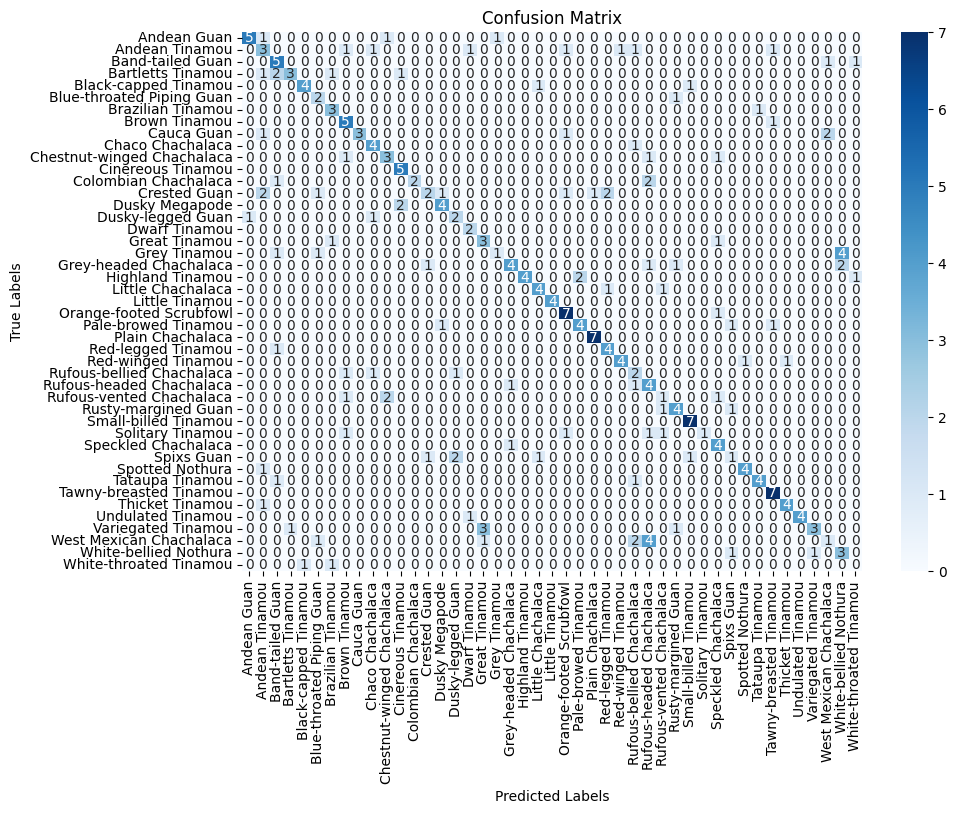

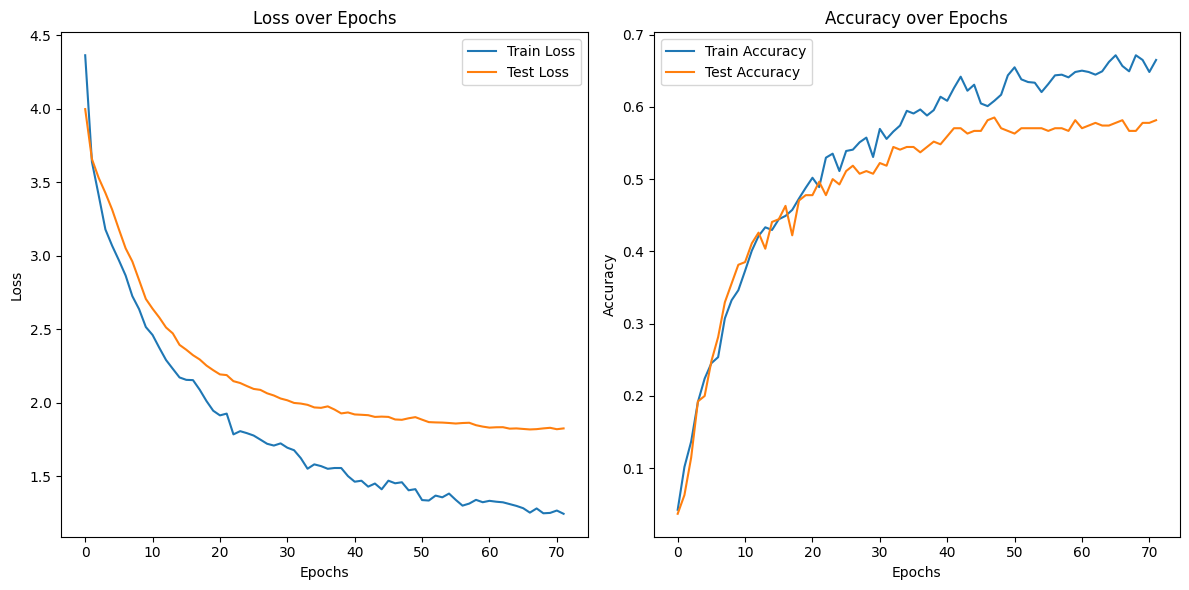

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predicted class for the sample: Rufous-vented Chachalaca


In [29]:
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Menggunakan np.argmax untuk mendapatkan kelas dengan probabilitas tertinggi
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)  # Ambil kelas dengan probabilitas tertinggi

# Menggunakan label_encoder untuk mengonversi y_test kembali ke label integer jika diperlukan
# Misalnya y_test sudah ter-encode, maka kita bisa langsung menggunakan y_test
# Pastikan y_test adalah integer encoded labels, bukan one-hot
# Misalnya, jika y_test sudah berupa integer (hasil transformasi dengan LabelEncoder), kita bisa menggunakan langsung.

y_test_int = label_encoder.transform(y_test)  # Mengubah y_test menjadi integer encoded jika diperlukan

# Menghitung akurasi prediksi
accuracy_pred = accuracy_score(y_test_int, y_pred)
print(f"Predicted Accuracy: {accuracy_pred}")

# Confusion Matrix
cm = confusion_matrix(y_test_int, y_pred)

# Visualisasi Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Plot Training and Testing Loss & Accuracy
plt.figure(figsize=(12, 6))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Contoh prediksi untuk sample dari X_test
sample_index = 0  # Ambil indeks sample pertama
sample = X_test[sample_index].reshape(1, X_test.shape[1], 1)  # Reshape untuk input model

# Prediksi label untuk sample
predicted_label = model.predict(sample)
predicted_class = label_encoder.inverse_transform([np.argmax(predicted_label)])

print(f"Predicted class for the sample: {predicted_class[0]}")

In [30]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Get predicted labels (integers) from model output
y_pred_labels = np.argmax(model.predict(X_test), axis=1)

# Convert one-hot encoded y_true to integer labels
y_true_labels = np.argmax(y_test_encoded, axis=1)

# Now, calculate metrics using the integer labels
accuracy = accuracy_score(y_true_labels, y_pred_labels)

precision = precision_score(y_true_labels, y_pred_labels, average='weighted')
recall = recall_score(y_true_labels, y_pred_labels, average='weighted')
f1 = f1_score(y_true_labels, y_pred_labels, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

print("\nClassification Report:")
print(classification_report(y_true_labels, y_pred_labels))

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Accuracy: 0.5814814814814815
Precision: 0.620181629070518
Recall: 0.5814814814814815
F1 Score: 0.5675479144115195

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.62      0.71         8
           1       0.30      0.30      0.30        10
           2       0.45      0.71      0.56         7
           3       0.75      0.38      0.50         8
           4       0.80      0.67      0.73         6
           5       0.40      0.67      0.50         3
           6       0.50      0.75      0.60         4
           7       0.50      0.83      0.62         6
           8       1.00      0.43      0.60         7
           9       0.57      0.80      0.67         5
          10       0.50      0.50      0.50         6
          11       0.62      1.00      0.77         5
          12       1.00      0.40      0.57         5
          13       0.50      0.20      0.29        10
          14 

In [31]:
df.groupby('labels')['labels'].count()

,labels
labels,
Andean Guan,30
Andean Tinamou,30
Band-tailed Guan,30
Bartletts Tinamou,30
Black-capped Tinamou,30
Blue-throated Piping Guan,30
Brazilian Tinamou,30
Brown Tinamou,30
Cauca Guan,30


In [32]:
import librosa
import numpy as np
from tensorflow.keras.models import load_model

# Fungsi untuk mengekstrak MFCC dari file audio
def extract_mfcc(file_path, n_mfcc=13):
    audio, sr = librosa.load(file_path, sr=None)
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    mfcc_mean = np.mean(mfcc, axis=1)  # Rata-rata untuk setiap koefisien MFCC
    return mfcc_mean

# Path ke file audio yang ingin diprediksi
example_file = '/content/drive/MyDrive/Birds Species Recognizing/Voice of Birds/Undulated Tinamou7.mp3'

# Ekstraksi fitur MFCC dari file audio
mfcc_features = extract_mfcc(example_file)

# Reshape untuk menyesuaikan dengan input model (1, n_features, 1)
mfcc_features_reshaped = mfcc_features.reshape(1, mfcc_features.shape[0], 1)

# Memuat model yang sudah dilatih (misalnya model yang telah disimpan sebelumnya)
# Jika model sudah dilatih sebelumnya, muat model dengan cara ini:
model = load_model('cnn.h5')  # Gantilah dengan path model Anda jika sudah disimpan

# Lakukan prediksi
predicted_prob = model.predict(mfcc_features_reshaped)
predicted_class = np.argmax(predicted_prob, axis=1)

# Mengonversi hasil prediksi kembali ke label asli menggunakan LabelEncoder
predicted_label = label_encoder.inverse_transform(predicted_class)

print(f"Predicted label for the audio file: {predicted_label[0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
Predicted label for the audio file: Undulated Tinamou


In [33]:
import librosa
import numpy as np
from tensorflow.keras.models import load_model

# Fungsi untuk mengekstrak MFCC dari file audio
def extract_mfcc(file_path, n_mfcc=13):
    audio, sr = librosa.load(file_path, sr=None)
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    mfcc_mean = np.mean(mfcc, axis=1)  # Rata-rata untuk setiap koefisien MFCC
    return mfcc_mean

# Path ke file audio yang ingin diprediksi
example_file = '/content/drive/MyDrive/Birds Species Recognizing/Voice of Birds/Tawny-breasted Tinamou15.mp3'

# Ekstraksi fitur MFCC dari file audio
mfcc_features = extract_mfcc(example_file)

# Reshape untuk menyesuaikan dengan input model (1, n_features, 1)
mfcc_features_reshaped = mfcc_features.reshape(1, mfcc_features.shape[0], 1)

# Memuat model yang sudah dilatih (misalnya model yang telah disimpan sebelumnya)
# Jika model sudah dilatih sebelumnya, muat model dengan cara ini:
model = load_model('cnn.h5')  # Gantilah dengan path model Anda jika sudah disimpan

# Lakukan prediksi
predicted_prob = model.predict(mfcc_features_reshaped)
predicted_class = np.argmax(predicted_prob, axis=1)

# Mengonversi hasil prediksi kembali ke label asli menggunakan LabelEncoder
predicted_label = label_encoder.inverse_transform(predicted_class)

print(f"Predicted label for the audio file: {predicted_label[0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
Predicted label for the audio file: Tawny-breasted Tinamou


In [34]:
model.save('cnn_tunning.h5')